In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
#Load dataset
df = pd.read_csv('../../Dataset/Palladium.csv')
df = df.reset_index()['Close']
df

0       1067.5
1       1096.0
2       1088.0
3       1102.5
4       1091.5
         ...  
2339     975.5
2340     968.0
2341     950.5
2342     914.5
2343     914.5
Name: Close, Length: 2344, dtype: float64

In [3]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [4]:
# 4. Split train and test data
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Function to create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# 6. Create train and test datasets
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(32))
model.add(Dense(1))

In [9]:
#Use Adam optimizer with learning rate = 0.001
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mean_squared_error')

In [10]:
#9. Fit model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stop])

Epoch 1/100
25/25 [==============================] - 26s 359ms/step - loss: 0.0339 - val_loss: 0.0022
Epoch 2/100
25/25 [==============================] - 5s 216ms/step - loss: 0.0034 - val_loss: 6.7865e-04
Epoch 3/100
25/25 [==============================] - 5s 217ms/step - loss: 0.0010 - val_loss: 2.9533e-04
Epoch 4/100
25/25 [==============================] - 7s 272ms/step - loss: 7.6614e-04 - val_loss: 2.9829e-04
Epoch 5/100
25/25 [==============================] - 8s 311ms/step - loss: 7.0337e-04 - val_loss: 3.0391e-04
Epoch 6/100
25/25 [==============================] - 6s 255ms/step - loss: 6.6402e-04 - val_loss: 2.8835e-04
Epoch 7/100
25/25 [==============================] - 6s 233ms/step - loss: 6.3779e-04 - val_loss: 3.0567e-04
Epoch 8/100
25/25 [==============================] - 6s 226ms/step - loss: 6.1444e-04 - val_loss: 2.6840e-04
Epoch 9/100
25/25 [==============================] - 5s 208ms/step - loss: 5.9542e-04 - val_loss: 2.7290e-04
Epoch 10/100
25/25 [==============

In [11]:
# 10. Predict test data
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

19/19 [==============================] - 3s 31ms/step


In [12]:
# 11. Inverse transform test data
train_data1 = df[:train_size]
test_data1 = df[train_size:]
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [13]:
# 12. Evaluate model accuracy
test_mse = mean_squared_error(y_test1[time_step + 1:], y_pred)
print('Testing MSE:', test_mse)

test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

test_mape = mean_absolute_percentage_error(y_test1[time_step + 1:], y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 1768.280124495277
Testing RMSE: 42.050922992192184
Testing MAPE: 0.02249186038919941


In [14]:
# 13. Define prediction function
def predict(n_steps, temp_input_1, x_input_1, model, day_predict):
    lst_output = []
    temp_input = temp_input_1.copy()
    x_input = x_input_1.copy()
    i = 0
    
    while(i < day_predict):
        if(len(temp_input) > n_steps):
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

In [15]:
# Predict next 30, 60, 90 days
n_steps = 100
x_input = test_data[len(test_data) - n_steps:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = predict(n_steps, temp_input, x_input, model, 30)
lst_output_60 = predict(n_steps, temp_input, x_input, model, 60)
lst_output_90 = predict(n_steps, temp_input, x_input, model, 90)

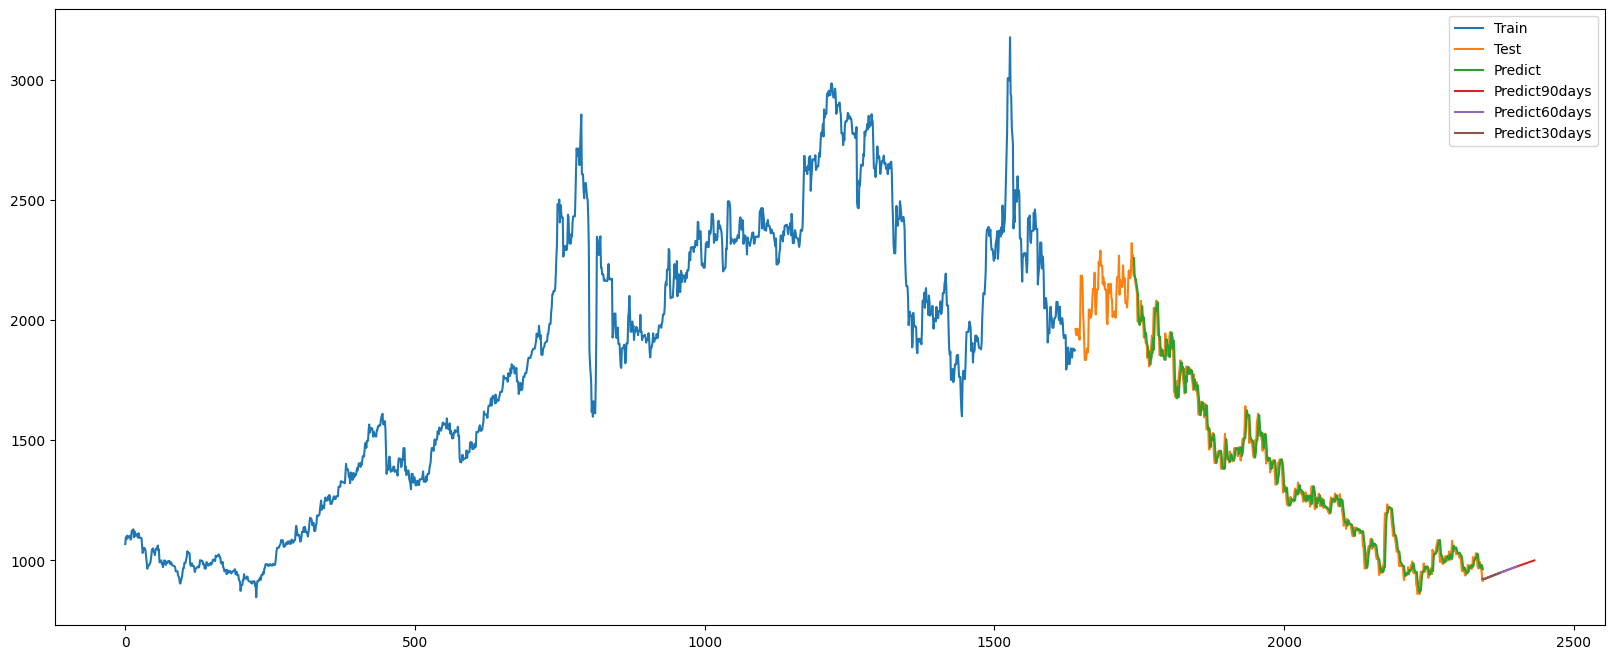

<Figure size 1600x900 with 0 Axes>

In [16]:
#Plot results
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_90))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
plt.figure(figsize=(16,9))
plt.show()